In [193]:
%matplotlib nbagg
import numpy as np
from scipy.optimize import minimize
from numpy.random import RandomState
import matplotlib.pyplot as plt



### 1.1 Dataset Construction

In [194]:
X = np.random.rand(150,75)
(N,D) = X.shape

In [195]:
theta_1 = np.empty(5)
theta_1.fill(10)

theta_2 = np.empty(5)
theta_2.fill(-10)

true_theta = np.hstack((theta_1,theta_2))
np.random.shuffle(true_theta)


In [196]:
theta_rest = np.zeros(65)
true_theta = np.hstack((true_theta,theta_rest))

In [197]:
epsilon = 0.1 * np.random.randn(150) + 0

In [198]:
y = np.dot(X,true_theta) + epsilon

In [199]:
#randState = RandomState(19910420)
np.random.seed(100)

In [200]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=42)

In [201]:
X_test,X_validation,y_test,y_validation = train_test_split(X_test, y_test, test_size=50, random_state=42)

### Question 1.2 Experiments with Ridge Regression

In [202]:
def ridge(X,y,theta,Lambda):
        def ridge_obj(theta):
          return ((np.linalg.norm(np.dot(X,theta) - y))**2)/(2*N) + Lambda*(np.linalg.norm(theta))**2
        return ridge_obj

def compute_loss(X,y,theta):
        return ((np.linalg.norm(np.dot(X,theta) - y))**2)/(2*N)

start = -5
end = 6
lam_range = abs(start - end)
lambda_loss = np.zeros((lam_range,2))

lambda_theta = np.zeros((lam_range,D))
for i in range(-5,6):
  Lambda = 10**i;
  theta_opt = minimize(ridge(X_train,y_train,np.zeros(D),Lambda), np.ones(D))
  lambda_loss[i] = Lambda, compute_loss(X_validation,y_validation,theta_opt.x)
  lambda_theta[i] = theta_opt.x

least_loss_lambda = lambda_loss[np.argmin(lambda_loss,axis=0)[1],[0]]
print 'least loss' , np.amin(lambda_loss,axis=0)[1]
theta_learned = lambda_theta[np.argmin(lambda_loss,axis=0)[1]]


least loss 0.0190747177814


<IPython.core.display.Javascript object>


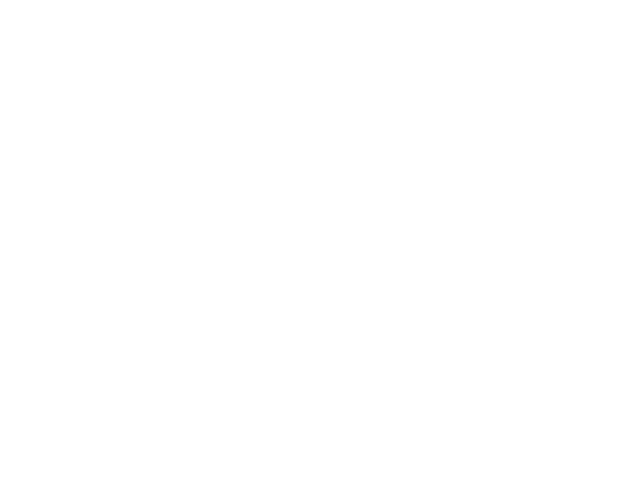

In [203]:
#plt.ylim(-1,1)
plt.xlabel("Coefficient index")
plt.ylabel("coefficient")
plt.plot(theta_learned,'r',label = "ridge solution")
plt.plot(true_theta,'g',label="true solution")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')
plt.title('Ridge solution Vs True solution')

plt.show()

In [204]:
plt.close()

### Comparison with sklearn Ridge

In [205]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

start = -5
end = 6
lam_range = abs(start - end)
sklearn_ridge_loss = np.zeros((lam_range,2))
sklearn_ridge_coef = np.zeros((lam_range,D))

for i in range(start,end):
    lamda = 10**i
    clf = Ridge(alpha=2*N*lamda)
    clf.fit(X_train, y_train)
    sklearn_ridge_loss[i] = lamda,mean_squared_error(clf.predict(X_validation), y_validation) / 2
    sklearn_ridge_coef[i] = clf.coef_

least_loss_lambda_sklearn = sklearn_ridge_loss[np.argmin(sklearn_ridge_loss,axis=0)[1],[0]]
print 'least loss sklearn' , np.amin(sklearn_ridge_loss,axis=0)[1]
sklearn_coef_learned = sklearn_ridge_coef[np.argmin(sklearn_ridge_loss,axis=0)[1]]    
#sklearn_ridge_coef = clf.coef_

least loss sklearn 0.0545802486991


#### plotting Validation loss for Ridge Experiment and sklearn Ridge w.r.t lamda

<IPython.core.display.Javascript object>


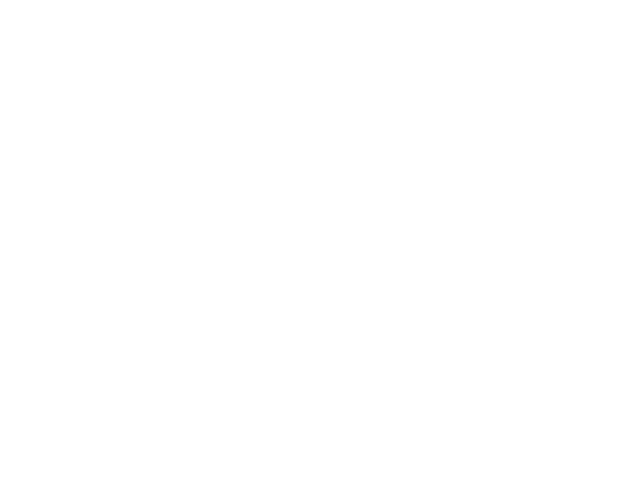

In [206]:
plt.xlabel("log lamda")
plt.ylabel("loss")
plt.ylim(-15,0)
plt.xlim(-6,6)
plt.plot(np.log(lambda_loss[:,1]),np.log(lambda_loss[:,0]),'r',label = "ridge solution")
plt.plot(np.log(sklearn_ridge_loss[:,1]),np.log(sklearn_ridge_loss[:,0]),'g',label="sklearn solution")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')
plt.title('Ridge solution Loss Vs sklearn Ridge Loss')

plt.show()

In [207]:
plt.close()

### Rescaling Solution with values < 10**-3 to be equal to 0

In [208]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 
y_obs = clf.predict(X_validation)

np.sum(y_obs - y_validation)

16.865454832633361

<IPython.core.display.Javascript object>


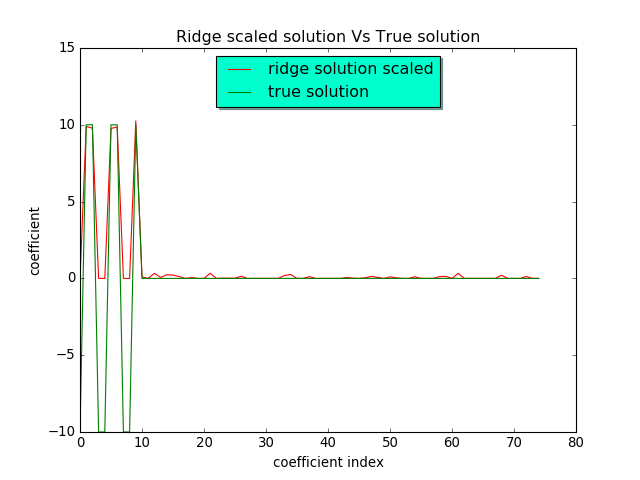

In [182]:
theta_scaled = theta_learned
theta_scaled[theta_scaled < 10**-3] = 0
#plt.ylim(-1,1)
plt.xlabel("coefficient index")
plt.ylabel("coefficient")
plt.plot(theta_scaled,'r',label = "ridge solution scaled")
plt.plot(true_theta,'g',label="true solution")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')
plt.title('Ridge scaled solution Vs True solution')

plt.show()



In [183]:
plt.close()

### 2.1 Experiments with Shooting Algorithm

In [184]:
def coordinate_descent(X,y,lamda,w):
    max_iter = 10000
    #print 'lamda in coordinte descent function  ' , lamda
    iter = 0
    converged = False
    while((not converged) and (iter < max_iter)):
        w_old = w
        for j in range(D):
            xij_factor = 0
            cj_factor = 0
            for i in range(X.shape[0]):
                xij_factor = X[i][j]**2 + xij_factor
                cj_factor = cj_factor + (X[i][j]*(y[i] - np.dot(w.T,X[i]) + w[j]*X[i][j]))

            aj = 2*xij_factor
            cj = 2*cj_factor
            if (cj > lamda):
                    w[j] = 1/aj*(cj - lamda)
            elif (cj < -lamda):
                    w[j] = 1/aj*(cj + lamda)
            else:
                    w[j] = 0
        iter = iter + 1
        converged = np.linalg.norm(np.absolute(w - w_old)) < 10 ** -3
    return w

In [185]:
start = -5
end = 3
lam_range = abs(start - end)

lasso_solutions = np.zeros((lam_range,D))
sq_loss_val_set = np.zeros(lam_range)
sq_loss_train = np.zeros(lam_range)
lamda_range = np.zeros(lam_range)

for i in range(start,end):
    lamda = 10**i
    lamda_range[i] = lamda
    w_starting_point =  theta_learned
    #theta_learned#np.dot(np.dot(np.linalg.inv(np.dot(X_train.T,X_train) + lamda * np.identity(X_train.shape[1])),X_train.T),y_train)
    #np.zeros(D)
    lasso_solutions[i] = coordinate_descent(X_train,y_train,lamda,w_starting_point)
    sq_loss_val_set[i] = compute_loss(X_validation,y_validation,lasso_solutions[i])
    sq_loss_train[i] = compute_loss(X_train,y_train,lasso_solutions[i])

best_lamda = lamda_range[np.argmin(sq_loss_val_set)]
test_lasso_sol = coordinate_descent(X_test,y_test,best_lamda,w_starting_point)
test_error = compute_loss(X_test,y_test,test_lasso_sol)

print "OBSERVATION: "
print "------------"
print "Best Lamda found is ", best_lamda, "with validation loss " , np.amin(sq_loss_val_set)
print "The Corresponding Test error is ", test_error
print 

OBSERVATION: 
------------
Best Lamda found is  100.0 with validation loss  10.2972703119
The Corresponding Test error is  1.64879683585



<IPython.core.display.Javascript object>


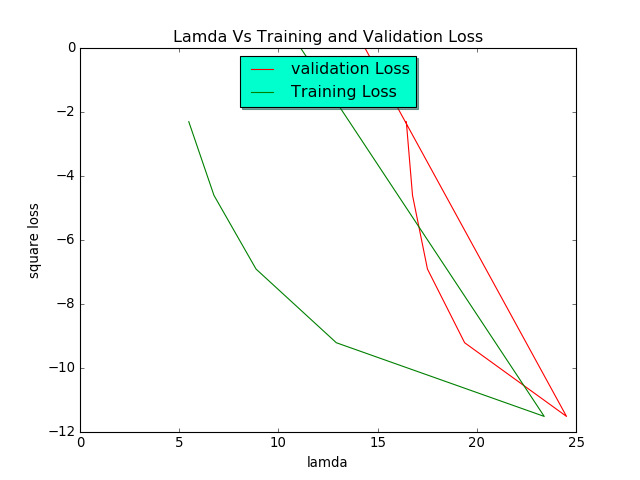

In [186]:
plt.xlabel("lamda")
plt.ylabel("square loss")
plt.ylim(-12,0)
plt.plot(sq_loss_val_set,np.log(lamda_range),'r',label = "validation Loss")
plt.plot(sq_loss_train,np.log(lamda_range),'g',label="Training Loss")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')
plt.title('Lamda Vs Training and Validation Loss')

plt.show()

In [187]:
plt.close()

## 2.2 Analyze the sparsity of solution

<IPython.core.display.Javascript object>


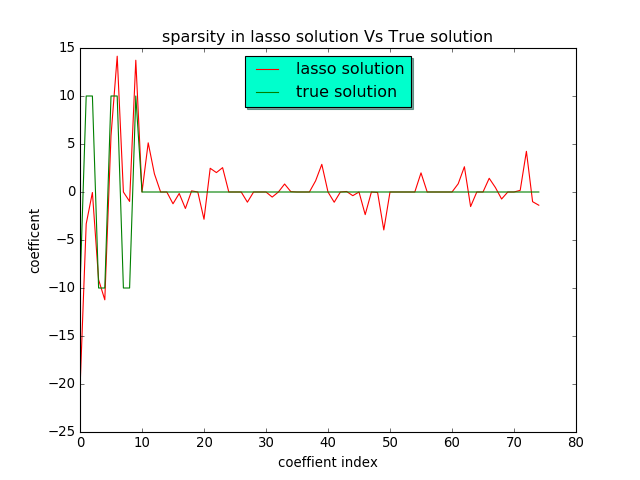

In [188]:
plt.xlabel("coeffient index")
plt.ylabel("coefficent")
plt.plot(lasso_solutions[np.argmin(sq_loss_val_set)],'r',label = "lasso solution")
plt.plot(true_theta,'g',label="true solution")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')
plt.title('sparsity in lasso solution Vs True solution')
plt.show()

In [189]:
plt.close()

## homotopy Method Vs Basic Shooting Algorithm

In [190]:
lamda_max = 2 * np.linalg.norm(np.dot(X_train.T,y_train))


 #### Run time for Basic Shooting Algorithm

In [191]:
import time
lamda = lamda_max
shooting_time = 0
while(lamda >= 10 ** -5):
        w = np.zeros(D)
        start_time = time.time()
        w = coordinate_descent(X_train,y_train,lamda,w)
        end_time = time.time()

        shooting_time = shooting_time + (end_time - start_time)

        lamda = float(lamda) / 2
print "OBSERVATION:"
print "------------"
print 'Time taken by shooting algorithm to compute the regularization path ', shooting_time


OBSERVATION:
------------
Time taken by shooting algorithm to compute the regularization path  0.570854663849


#### Run-time for homotopy method

In [192]:
lamda = lamda_max
homotopy_time = 0
w = np.zeros(D)
while(lamda >= 10 ** -5):
        start_time = time.time()
        w = coordinate_descent(X_train,y_train,lamda,w)
        end_time = time.time()

        homotopy_time = homotopy_time + (end_time - start_time)
        lamda = float(lamda) / 2

print "OBSERVATION :"
print "-------------"
print "Time taken by homotopy method is  to compute the regularization path" , homotopy_time

OBSERVATION :
-------------
Time taken by homotopy method is  to compute the regularization path 0.603389263153


## Vectorized Code for Coordinate Descent a.k.a Shooting Algorithm

In [98]:
def vect_coordinate_descent(X,y,lamda,w):
    max_iter = 10000
    #print 'lamda in coordinte descent function  ' , lamda
    iter = 0
    converged = False
    XX2 = np.dot(X.T,X)*2
    Xy2 = np.dot(X.T,y)*2;

    while((not converged) and (iter < max_iter)):
        w_old = w
        for j in range(D):
            aj = XX2[j][j]
            cj = 2 * np.sum(np.multiply(X[:,j],(y-np.dot(X,w.T)+w[j]*X[:,j])))

            if (cj > lamda):
                    w[j] = 1/aj*(cj - lamda)
            elif (cj < -lamda):
                    w[j] = 1/aj*(cj + lamda)
            else:
                    w[j] = 0
        iter = iter + 1
        converged = np.linalg.norm(np.absolute(w - w_old)) < 10 ** -3
    return w

In [99]:
lamda = lamda_max
vect_time = 0
w = np.zeros(D)
while(lamda >= 10 ** -5):
        start_time = time.time()
        w = vect_coordinate_descent(X_train,y_train,lamda,w)
        end_time = time.time()

        vect_time = vect_time + (end_time - start_time)
        lamda = float(lamda) / 2
print "OBSERVATION :"
print "-------------"
print 'Time taken by vectorized code to compute the regularization path is  ' , vect_time

OBSERVATION :
-------------
Time taken by vectorized code is   0.0834672451019


### OBSERVATION:

Time Taken by Vectorized Code < Homotopy < Basic Shooting with loops